In [1]:
pwd

'/home/jovyan/private/PycharmProjects/FlexGen-EHR-master/FlexGen-master'

In [2]:
from models.cvae import VariationalAutoencoder, vae_loss_fn
from models.ddpm import DDPM, ContextUnet
from models.flexgen import flexgen
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pandas as pd
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

class MIMICDATASET(Dataset):
    def __init__(self, x_t,x_s, y, train=None, transform=None):
        # Transform
        self.transform = transform
        self.train = train
        self.xt = x_t
        self.xs = x_s
        self.y = y

    def return_data(self):
        return self.xt, self.xs, self.label

    def __len__(self):
        return len(self.xt)

    def __getitem__(self, idx):
        sample = self.xt[idx]
        stat = self.xs[idx]
        sample_y = self.y[idx]
        return sample, stat, sample_y

In [3]:
batch_size =  512
device = torch.device("cuda")
tasks = [
    'mortality_48h',
    'ARF_4h', 
    'ARF_12h',
    'Shock_4h',
    'Shock_12h',
]
task = tasks[0]
s = np.load('FIDDLE_mimic3/features/{}/s.npz'.format(task))
X = np.load('FIDDLE_mimic3/features/{}/X.npz'.format(task))
s_feature_names = json.load(open('FIDDLE_mimic3/features/{}/s.feature_names.json'.format(task), 'r'))
X_feature_names = json.load(open('FIDDLE_mimic3/features/{}/X.feature_names.json'.format(task), 'r'))
df_pop = pd.read_csv('FIDDLE_mimic3/population/{}.csv'.format(task))
x_s = torch.sparse_coo_tensor(torch.tensor(s['coords']), torch.tensor(s['data'])).to_dense().to(torch.float32)
x_t = torch.sparse_coo_tensor(torch.tensor(X['coords']), torch.tensor(X['data'])).to_dense().to(torch.float32)

print(x_s.shape)
print(x_t.shape)

x_t = x_t.sum(dim=1).to(torch.float32)

print(x_t.shape)


y = torch.tensor(df_pop["mortality_LABEL"].values).to(torch.float32)
print(y.shape)
dataset_train_object = MIMICDATASET(x_t, x_s, y,  train=True, transform=False)
train_loader = DataLoader(dataset_train_object, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=False)

torch.Size([8577, 96])
torch.Size([8577, 48, 7307])
torch.Size([8577, 7307])
torch.Size([8577])


loss: 0.6548: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


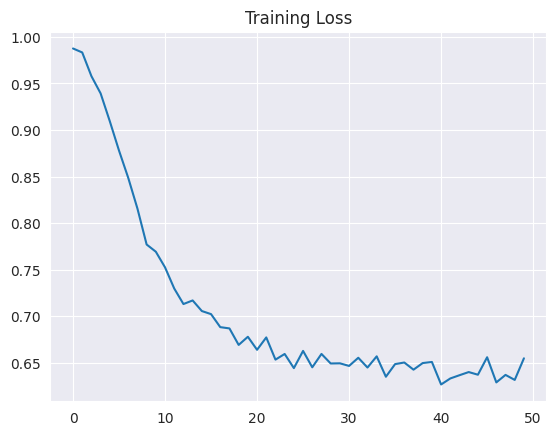


torch.Size([2000, 128]) torch.Size([2000, 128])
torch.Size([2000, 7307]) torch.Size([2000, 96])


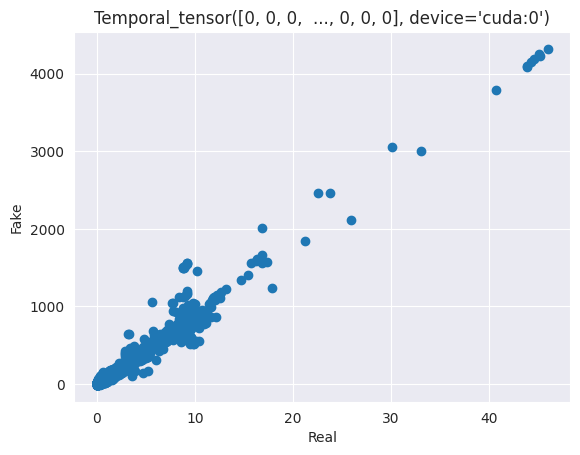

/home/jovyan/private/PycharmProjects/FlexGen-EHR-master/FlexGen-master/models/flexgen.py:108: RuntimeWarning: overflow encountered in exp
  s_syn = np.round(1 / (1 + np.exp(-s_syn)))


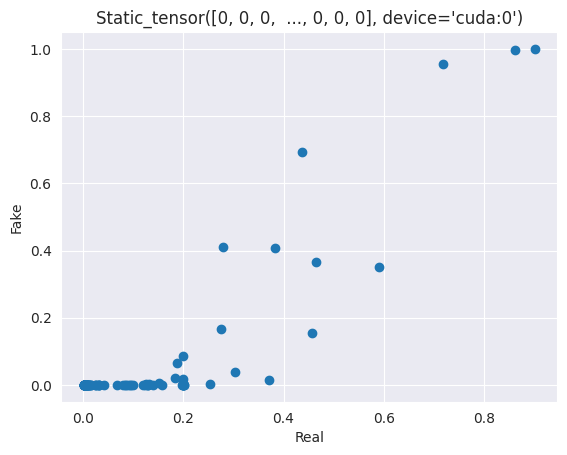


torch.Size([2000, 128]) torch.Size([2000, 128])
torch.Size([2000, 7307]) torch.Size([2000, 96])


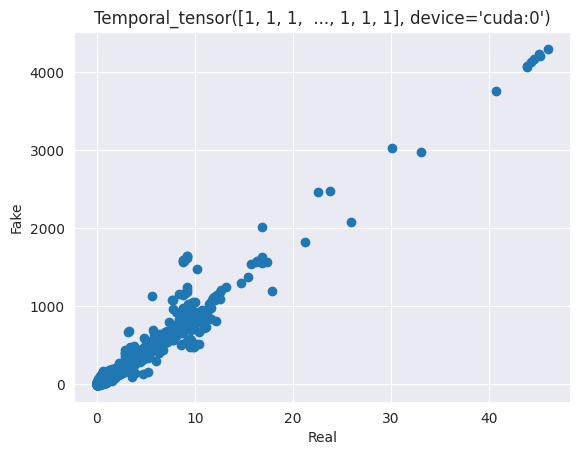

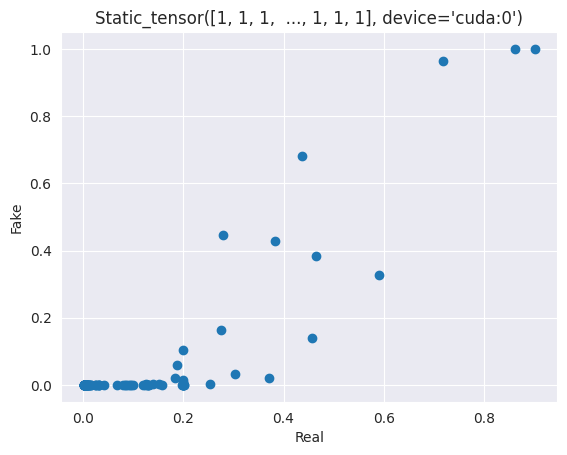

In [4]:
# 필요한 값만 언팩
tmp_samples, sta_samples, _ = next(iter(train_loader))
feature_dim_s = sta_samples.shape[1]
feature_dim_t = tmp_samples.shape[1]

svae = VariationalAutoencoder(feature_dim_s).to(device)
tvae = VariationalAutoencoder(feature_dim_t).to(device)
tvae_dict = torch.load('saved_models/vae_tmp.pth', weights_only=True)
svae_dict = torch.load('saved_models/vae_stat.pth', weights_only=True)
tvae.load_state_dict(tvae_dict)
svae.load_state_dict(svae_dict)
svae.eval()
tvae.eval()
n_epoch = 50
n_T = 1000
device = "cuda"
n_classes = 2
n_feat = 256
lrate = 1e-4
save_model = True
w = 0.1
ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=2), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)
trainer = flexgen(tvae, svae, ddpm, train_loader, epochs=n_epoch, model_path='saved_models/flexgenDiff.pth')
trainer.train_epoch()

s0_syn, t0_syn = trainer.generate(2000, 0)
s1_syn, t1_syn = trainer.generate(2000, 1)

s_syn = np.concatenate([s0_syn, s1_syn], axis=0)
t_syn = np.concatenate([t0_syn, t1_syn], axis=0)

np.save('Synthetic_MIMIC/flexgen_static.npy', s_syn)
np.save('Synthetic_MIMIC/flexgen_temporal.npy', t_syn)

In [5]:
print(s_rp.min(), s_rp.max(), s_rp.mean())
print(s_fp.min(), s_fp.max(), s_fp.mean())
print(t_rp.min(), t_rp.max(), t_rp.mean())
print(t_fp.min(), t_fp.max(), t_fp.mean())

NameError: name 's_rp' is not defined

In [6]:
s_syn = np.load('Synthetic_MIMIC/flexgen_static.npy')
t_syn = np.load('Synthetic_MIMIC/flexgen_temporal.npy')
print(s_syn.shape, t_syn.shape)

(4000, 96) (4000, 7307)
